In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import keras

CLEAN_DATA_FOLDER = "/content/drive/Shareddrives/Data 270 DAP Group Project_QQP/clean_data"
MODEL_DATA_FOLDER = "/content/drive/Shareddrives/Data 270 DAP Group Project_QQP/final/LSTM - Saumya"
LEARNING_RATE = 1e-3  # Adjusted learning rate
BATCH_SIZE = 64  # Adjusted batch size for potentially better learning
EPOCHS = 30  # Adjusted number of epochs to avoid overfitting


In [31]:

# Load and prepare training data
train_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "train.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    }
)

validation_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "validation.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    },
)


In [32]:

# Convert lists into TensorFlow ragged tensors
train_X_0 = tf.ragged.constant(train_df["question1"].tolist())
train_X_1 = tf.ragged.constant(train_df["question2"].tolist())
train_Y = tf.ragged.constant(train_df["is_duplicate"].tolist(), dtype=tf.float32)

validation_X_0 = tf.ragged.constant(validation_df["question1"].tolist())
validation_X_1 = tf.ragged.constant(validation_df["question2"].tolist())
validation_Y = tf.ragged.constant(validation_df["is_duplicate"].tolist(), dtype=tf.float32)

# Function to pad inputs for uniformity
def pad_inputs(inputs, outputs):
    return (
        (inputs[0].to_tensor(default_value=0), inputs[1].to_tensor(default_value=0)),
        tf.expand_dims(outputs, axis=-1),
    )



In [33]:

# Prepare dataset for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices(((train_X_0, train_X_1), train_Y))
train_dataset = train_dataset.shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_X_0, validation_X_1), validation_Y))
validation_dataset = validation_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)


In [34]:
def get_embedding_layer(embed_name="fasttext", embed_dim=100):
    embedding_matrix = np.load(os.path.join(CLEAN_DATA_FOLDER, f"{embed_name}.{embed_dim}d.embeddings.npy"))
    embedding_layer = keras.layers.Embedding(embedding_matrix.shape[0], embed_dim, name=f"{embed_name}")
    embedding_layer.build((1,))
    embedding_layer.trainable = False
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

In [35]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda, Subtract

# Model creation function
def create_lstm_model(embed_name="fasttext", embed_dim=100):
    question1 = Input(shape=(None,), dtype='int32', name="question1")
    question2 = Input(shape=(None,), dtype='int32', name="question2")

    embedding_layer = get_embedding_layer(embed_name, embed_dim)

    q1_embed = embedding_layer(question1)
    q2_embed = embedding_layer(question2)

    lstm_layer = keras.layers.LSTM(128, return_sequences=False)
    q1_encoded = lstm_layer(q1_embed)
    q2_encoded = lstm_layer(q2_embed)

    concatenated = keras.layers.concatenate([q1_encoded, q2_encoded])
    dense1 = keras.layers.Dense(64, activation='relu')(concatenated)
    output = keras.layers.Dense(1, activation='sigmoid')(dense1)

    model = keras.Model(inputs=[question1, question2], outputs=output)
    return model

model = create_lstm_model()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 question1 (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 question2 (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 fasttext (Embedding)        (None, None, 100)            1128020   ['question1[0][0]',           
                                                          0          'question2[0][0]']           
                                                                                                  
 lstm_1 (LSTM)               (None, 128)                  117248    ['fasttext[0][0]',      

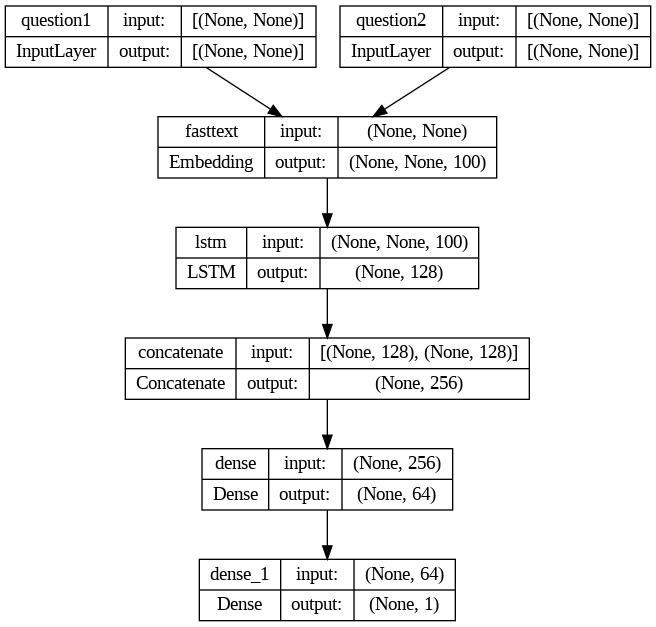

In [ ]:
keras.utils.plot_model(
    model,
    to_file=os.path.join(MODEL_DATA_FOLDER, "lstm_model_fasttext.png"),
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:

# Model compilation
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

# Model training
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True)]
)

Epoch 1/30
6477/6477 [==============================] - 570s 87ms/step - loss: 0.5567 - binary_accuracy: 0.7084 - auc_1: 0.7838 - val_loss: 0.5487 - val_binary_accuracy: 0.7156 - val_auc_1: 0.7863
Epoch 2/30
6477/6477 [==============================] - 554s 85ms/step - loss: 0.4909 - binary_accuracy: 0.7565 - auc_1: 0.8405 - val_loss: 0.5310 - val_binary_accuracy: 0.7311 - val_auc_1: 0.8149
Epoch 3/30
6477/6477 [==============================] - 552s 85ms/step - loss: 0.4566 - binary_accuracy: 0.7784 - auc_1: 0.8647 - val_loss: 0.5204 - val_binary_accuracy: 0.7350 - val_auc_1: 0.8317
Epoch 4/30
6477/6477 [==============================] - 546s 84ms/step - loss: 0.4298 - binary_accuracy: 0.7943 - auc_1: 0.8815 - val_loss: 0.4714 - val_binary_accuracy: 0.7710 - val_auc_1: 0.8482
Epoch 5/30
6477/6477 [==============================] - 529s 81ms/step - loss: 0.4088 - binary_accuracy: 0.8063 - auc_1: 0.8936 - val_loss: 0.4473 - val_binary_accuracy: 0.7856 - val_auc_1: 0.8605
Epoch 6/30
6477

In [ ]:
import matplotlib.pyplot as plt


# Extracting accuracy and loss from the history object
train_acc = history.history['binary_accuracy']
val_acc = history.history.get('val_binary_accuracy')
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')
epochs = range(1, len(train_acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
if val_acc:
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# to save model
model.save(os.path.join(MODEL_DATA_FOLDER, "lstm_fasttext_final.keras"))

In [7]:
#load model
loaded_model = keras.saving.load_model(os.path.join(MODEL_DATA_FOLDER, "lstm_fasttext_final.keras"))

In [8]:
# Load test data
test_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "test.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    }
)

# Convert lists into TensorFlow ragged tensors
test_X_0 = tf.ragged.constant(test_df["question1"].tolist())
test_X_1 = tf.ragged.constant(test_df["question2"].tolist())
test_Y = tf.ragged.constant(test_df["is_duplicate"].tolist(), dtype=tf.float32)

# Function to pad inputs for uniformity, reused from earlier
def pad_inputs(inputs, outputs):
    return (
        (inputs[0].to_tensor(default_value=0), inputs[1].to_tensor(default_value=0)),
        tf.expand_dims(outputs, axis=-1),
    )

# Prepare dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices(((test_X_0, test_X_1), test_Y))
test_dataset = test_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# # Load validation data
# validation_df = pd.read_csv(
#     os.path.join(CLEAN_DATA_FOLDER, "validation.tsv"),
#     sep="\t",
#     converters={
#         "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#         "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#     }
# )

# # Convert lists into TensorFlow ragged tensors
# val_X_0 = tf.ragged.constant(validation_df["question1"].tolist())
# val_X_1 = tf.ragged.constant(validation_df["question2"].tolist())
# val_Y = tf.ragged.constant(validation_df["is_duplicate"].tolist(), dtype=tf.float32)

# # Function to pad inputs for uniformity, reused from earlier
# def pad_inputs(inputs, outputs):
#     return (
#         (inputs[0].to_tensor(default_value=0), inputs[1].to_tensor(default_value=0)),
#         tf.expand_dims(outputs, axis=-1),
#     )

# # Prepare dataset for validating
# val_dataset = tf.data.Dataset.from_tensor_slices(((val_X_0, val_X_1), val_Y))
# val_dataset = val_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
predicted_labels = model.predict(test_dataset)

632/632 [==============================] - 3s 4ms/step


In [ ]:
evaluation_results = model.evaluate(test_dataset)

632/632 [==============================] - 4s 5ms/step - loss: 0.5004 - binary_accuracy: 0.8113 - auc: 0.8850


In [ ]:
# Evaluate the model on the test set
evaluation_results = model.evaluate(test_dataset)
print("Test Loss:", evaluation_results[0])
print("Test Binary Accuracy:", evaluation_results[1])
print("Test AUC:", evaluation_results[2])

632/632 [==============================] - 3s 4ms/step - loss: 0.5004 - binary_accuracy: 0.8113 - auc: 0.8850
Test Loss: 0.5004040002822876
Test Binary Accuracy: 0.8112890124320984
Test AUC: 0.8850342631340027


In [ ]:
# # Evaluate the model on the validation set
# evaluation_results_val = loaded_model.evaluate(val_dataset)
# print("Validation Loss:", evaluation_results_val[0])
# print("Validation Binary Accuracy:", evaluation_results_val[1])
# print("Validation AUC:", evaluation_results_val[2])

632/632 [==============================] - 3s 4ms/step - loss: 0.4486 - binary_accuracy: 0.8205 - auc: 0.8899
Validation Loss: 0.44859999418258667
Validation Binary Accuracy: 0.8204652070999146
Validation AUC: 0.8899003863334656


In [9]:
from sklearn.metrics import (ConfusionMatrixDisplay,PrecisionRecallDisplay,RocCurveDisplay,confusion_matrix,accuracy_score,
    precision_score,recall_score,f1_score,roc_curve,precision_recall_curve,roc_auc_score,average_precision_score,auc)


In [10]:
test_y_pred = loaded_model.predict(test_dataset)
test_results_df = pd.DataFrame(
    {
        "y_true": test_df["is_duplicate"].tolist(),
        "y_pred": test_y_pred.round().astype(int).squeeze().tolist(),
        "y_score": test_y_pred.squeeze().tolist(),
    }
)

632/632 [==============================] - 27s 41ms/step


In [16]:
test_metrics = {
    "Accuracy": {},
    "Precision": {},
    "Recall": {},
    "F1": {},
    "ROC AUC": {},
    "PR AUC": {}
}

model_name = "LSTM (Fasttext)"

In [17]:
accuracy = accuracy_score(test_results_df["y_true"], test_results_df["y_pred"])
precision = precision_score(test_results_df["y_true"], test_results_df["y_pred"])
recall = recall_score(test_results_df["y_true"], test_results_df["y_pred"])
f1 = f1_score(test_results_df["y_true"], test_results_df["y_pred"])
auc_roc = roc_auc_score(test_results_df["y_true"], test_results_df["y_score"])
pr, re, _ = precision_recall_curve(
    test_results_df["y_true"], test_results_df["y_score"], pos_label=1
)
auc_pr = auc(re, pr)
test_metrics["Accuracy"][model_name] = accuracy
test_metrics["Precision"][model_name] = precision
test_metrics["Recall"][model_name] = recall
test_metrics["F1"][model_name] = f1
test_metrics["ROC AUC"][model_name] = auc_roc
test_metrics["PR AUC"][model_name] = auc_pr
pd.DataFrame(test_metrics)
pd.DataFrame(test_metrics).to_csv("temp_results.csv", index_label="Model")
pd.DataFrame(test_metrics)

,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC
LSTM (Fasttext),0.811289,0.721688,0.802659,0.760023,0.886861,0.827913


In [15]:
# Plotting the matrices

In [22]:
# Calculate the confusion matrix
cm = confusion_matrix(test_results_df["y_true"], test_results_df["y_pred"])

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[20709  4657]
 [ 2969 12076]]


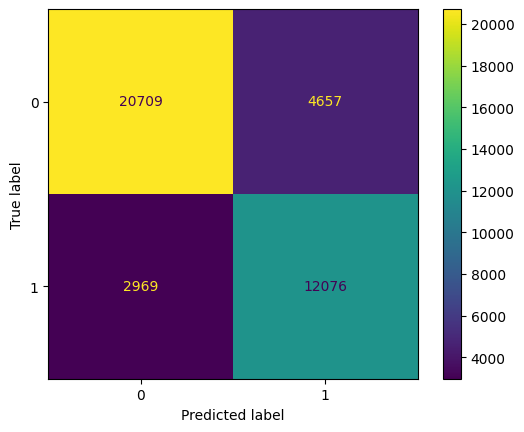

In [23]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show()

# **Inferencing**

In [ ]:
import pandas as pd
import tensorflow as tf

# Load the vocabulary
vocab_path = '/content/drive/MyDrive/clean_data/vocab.tsv'
vocab = pd.read_csv(vocab_path, sep='\t')
vocab_mapping = {row['token']: row['id'] for index, row in vocab.iterrows()}

In [ ]:
def tokenize_and_encode(question, vocab_mapping, max_length=64):
    # Convert text to lowercase, then to words (tokens)
    tokens = tf.keras.preprocessing.text.text_to_word_sequence(question)

    # Replace each token with its corresponding ID from the vocab_mapping
    encoded = [vocab_mapping.get(token, 0) for token in tokens]  # Use 0 for unknown words

    # Pad the sequences to ensure uniform input size
    padded = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen=max_length, padding='post')
    return padded


In [ ]:
def predict_similarity(question1, question2, vocab_mapping, model, max_length=64):
    # Encode the questions
    q1_encoded = tokenize_and_encode(question1, vocab_mapping, max_length)
    q2_encoded = tokenize_and_encode(question2, vocab_mapping, max_length)

    # Predict using the trained LSTM model
    prediction = model.predict([q1_encoded, q2_encoded])

    # Interpret the prediction as similar or not based on a threshold (e.g., 0.5)
    is_similar = 'Similar' if prediction[0][0] > 0.5 else 'Not Similar'

    return is_similar


In [ ]:
# Example questions
question1 = "How can I improve my English speaking?"
question2 = "What are some ways to become better at speaking English?"

# Assuming 'model' is your trained LSTM model
result = predict_similarity(question1, question2, vocab_mapping, model)
print("The questions are:", result)


1/1 [==============================] - 1s 719ms/step
The questions are: Similar


In [ ]:
# Example questions
question2 = "How to run GPU on colab ?"
question3 = "I am not able to run GPU, can someone tell me the steps for it ?"

# Assuming 'model' is your trained LSTM model
result = predict_similarity(question2, question3, vocab_mapping, model)
print("The questions are:", result)


1/1 [==============================] - 0s 63ms/step
The questions are: Similar
